# Data Preparation

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
datasetPath = "/content/drive/MyDrive/Thesis/Code/GenerativeDataAugmentation/Coba18 - Testing All Dataset/augJoin - AllDataset - unfiltered.csv"
dataset = pd.read_csv(datasetPath, index_col=0, encoding="utf-8")
dataset

,Text,Emotion
0,i am feeling ungrateful all the time,sadness
1,i am not feeling like ive missed anything,sadness
2,"But why will it ""activate""??? Will this make m...",sadness
3,i didn t mind going but as i neared the end of...,sadness
4,i wish i could do this but unfortunately i fee...,sadness
...,...,...
65023,I love truck drivers!!,love
65024,I knew I'd see him here eventually. I really l...,joy
65025,Nope what’s it about?,surprise
65026,Removed and warned. R1,anger


In [3]:
dataset.rename(columns={'text' : 'Text', 'emotion' : 'Emotion'}, inplace=True)

In [4]:
dataset

,Text,Emotion
0,i am feeling ungrateful all the time,sadness
1,i am not feeling like ive missed anything,sadness
2,"But why will it ""activate""??? Will this make m...",sadness
3,i didn t mind going but as i neared the end of...,sadness
4,i wish i could do this but unfortunately i fee...,sadness
...,...,...
65023,I love truck drivers!!,love
65024,I knew I'd see him here eventually. I really l...,joy
65025,Nope what’s it about?,surprise
65026,Removed and warned. R1,anger


In [5]:
dataset = dataset[dataset.Emotion != 'love']

In [6]:
dataset['Emotion'].value_counts().sort_index()

anger       13940
disgust     13037
fear        13870
joy         14744
sadness     14480
surprise    13284
Name: Emotion, dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

dataset['emotion_encode'] = le.fit_transform(dataset['Emotion'])
dataset.head()

<ipython-input-7-f27a98eed3b1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['emotion_encode'] = le.fit_transform(dataset['Emotion'])


,Text,Emotion,emotion_encode
0,i am feeling ungrateful all the time,sadness,4
1,i am not feeling like ive missed anything,sadness,4
2,"But why will it ""activate""??? Will this make m...",sadness,4
3,i didn t mind going but as i neared the end of...,sadness,4
4,i wish i could do this but unfortunately i fee...,sadness,4


In [8]:
le_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_mapping)

{'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'sadness': 4, 'surprise': 5}


In [9]:
LABEL_NAME = le.classes_
print(LABEL_NAME)

['anger' 'disgust' 'fear' 'joy' 'sadness' 'surprise']


In [10]:
emotion_col = dataset.pop("Emotion")
emotion_col

0         sadness
1         sadness
2         sadness
3         sadness
4         sadness
           ...   
65022       anger
65024         joy
65025    surprise
65026       anger
65027       anger
Name: Emotion, Length: 83355, dtype: object

In [11]:
training_data, validation_data, test_data = np.split(dataset.sample(frac=1), [int(.8*len(dataset)), int(.9*len(dataset))])

In [12]:
print(training_data.shape)
print(validation_data.shape)
print(test_data.shape)

(66684, 2)
(8335, 2)
(8336, 2)


# One-hot Vector

In [13]:
trainX = np.array(training_data.iloc[:, 0])
trainY = np.array(training_data.iloc[:, 1])

testX = np.array(test_data.iloc[:, 0])
testY = np.array(test_data.iloc[:, 1])

valX = np.array(validation_data.iloc[:, 0])
valY = np.array(validation_data.iloc[:, 1])

In [14]:
trainY = pd.get_dummies(trainY).values
testY = pd.get_dummies(testY).values
valY = pd.get_dummies(valY).values

In [15]:
print(trainY.shape)
print(testY.shape)
print(valY.shape)

(66684, 6)
(8336, 6)
(8335, 6)


In [16]:
vocab_size = 5000
embedding_dim = 64
max_length = 80
oov_tok = '<OOV>'
trunc_type = 'pre'
padding_type = 'pre'

# Tokenizing, Sequencing, Padding

In [17]:
#Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(trainX)

tokenizer.word_index[''] = 0
tokenizer.index_word[0] = ''

word_index = tokenizer.word_index

In [18]:
len(word_index)

26104

In [19]:
vocab_size = len(tokenizer.word_index)
vocab_size

26104

In [20]:
#Sequencing
train_seqs = tokenizer.texts_to_sequences(trainX)
val_seqs = tokenizer.texts_to_sequences(valX)
test_seqs = tokenizer.texts_to_sequences(testX)

In [21]:
#Padding
train_seqs = pad_sequences(train_seqs, maxlen=max_length, padding=padding_type, truncating=trunc_type)
val_seqs = pad_sequences(val_seqs, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_seqs = pad_sequences(test_seqs, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Model Training

In [22]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1670656   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1,745,350
Trainable params: 1,745,350
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10

In [24]:
%%time
history = model.fit(train_seqs, trainY, epochs=num_epochs, validation_data=(val_seqs, valY), verbose=1)

Epoch 1/10
2084/2084 [==============================] - 46s 18ms/step - loss: 1.1360 - accuracy: 0.5685 - val_loss: 0.9077 - val_accuracy: 0.6697
Epoch 2/10
2084/2084 [==============================] - 20s 10ms/step - loss: 0.8405 - accuracy: 0.6979 - val_loss: 0.8815 - val_accuracy: 0.6805
Epoch 3/10
2084/2084 [==============================] - 18s 9ms/step - loss: 0.7756 - accuracy: 0.7187 - val_loss: 0.8775 - val_accuracy: 0.6794
Epoch 4/10
2084/2084 [==============================] - 19s 9ms/step - loss: 0.7316 - accuracy: 0.7334 - val_loss: 0.8857 - val_accuracy: 0.6789
Epoch 5/10
2084/2084 [==============================] - 19s 9ms/step - loss: 0.6893 - accuracy: 0.7458 - val_loss: 0.9030 - val_accuracy: 0.6789
Epoch 6/10
2084/2084 [==============================] - 19s 9ms/step - loss: 0.6495 - accuracy: 0.7593 - val_loss: 0.9282 - val_accuracy: 0.6794
Epoch 7/10
2084/2084 [==============================] - 18s 9ms/step - loss: 0.6084 - accuracy: 0.7729 - val_loss: 0.9787 - val_

# Evaluation

In [25]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

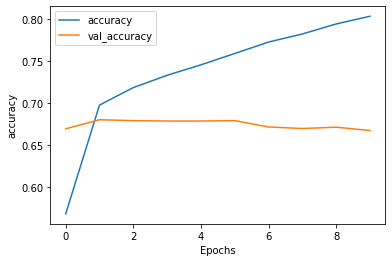

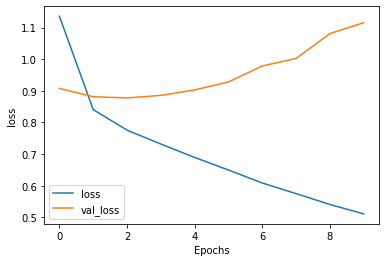

In [26]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [27]:
print('\nEpoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss')
for i in range(num_epochs):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, history.history['accuracy'][i], history.history['loss'][i], history.history['val_accuracy'][i], history.history['val_loss'][i]))


Epoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss
       1   0.568502 	   1.136039 	   0.669706 	   0.907693
       2   0.697904 	   0.840493 	   0.680504 	   0.881486
       3   0.718733 	   0.775567 	   0.679424 	   0.877547
       4   0.733354 	   0.731649 	   0.678944 	   0.885655
       5   0.745771 	   0.689292 	   0.678944 	   0.902977
       6   0.759268 	   0.649466 	   0.679424 	   0.928186
       7   0.772884 	   0.608431 	   0.671866 	   0.978697
       8   0.782482 	   0.574822 	   0.670066 	   1.002483
       9   0.794388 	   0.540404 	   0.671626 	   1.081282
      10   0.803566 	   0.510614 	   0.667666 	   1.115831


In [28]:
y_pred = np.argmax(model.predict(test_seqs), axis=1)
y_true = np.argmax(testY, axis=1)

loss, accuracy = model.evaluate(test_seqs, testY)

261/261 [==============================] - 1s 5ms/step - loss: 1.1470 - accuracy: 0.6599


In [29]:
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58      1389
           1       0.46      0.47      0.47      1267
           2       0.68      0.73      0.70      1325
           3       0.81      0.77      0.79      1540
           4       0.73      0.72      0.72      1448
           5       0.67      0.67      0.67      1367

    accuracy                           0.66      8336
   macro avg       0.66      0.66      0.66      8336
weighted avg       0.66      0.66      0.66      8336

